In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


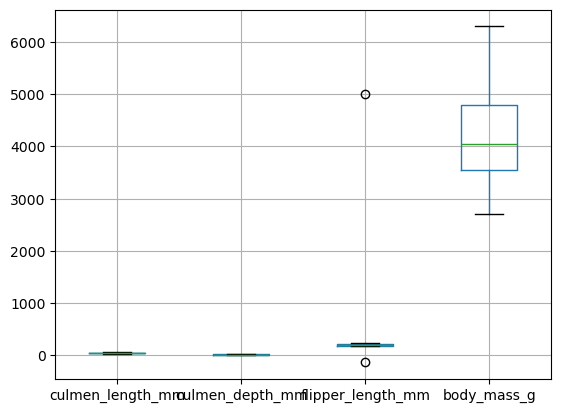

In [2]:
df = pd.read_csv("penguins.csv")
df = df.dropna()             # Delete missing data
df = df.drop("sex", axis=1)  # Dropping sex because we want K means clustering and not K mode clustering

df.boxplot()
df.head()

Dropping outliers (see boxplot)

In [4]:
df = df.drop(df[df["flipper_length_mm"] > 1000].index)
df = df.drop(df[df["flipper_length_mm"] < 0].index)

<Axes: >

In [5]:
# Min Max Scaling

df = ( (df - df.min()) / (df.max() - df.min()) ) * 9 + 1

df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,3.290909,7.000000,2.372881,3.625
1,3.421818,5.607143,3.135593,3.750
2,3.683636,6.250000,4.508475,2.375
4,2.505455,7.642857,4.203390,2.875
5,3.356364,9.035714,3.745763,3.375


# STEP 1
    Pick k random centroids for the k clusters (picking k random rows)

In [6]:
def init_random_cluster_centroids(df, k):
    return df.sample(n=k).reset_index(drop=True).T

# STEP 2
    Calculate euclidean distance from the data points to the centroids of the clusters

In [7]:
def get_cluster_label(df, cluster_centroid):
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)) )  # Euclidean distance
    distances = distances.idxmin(axis=1)
    return distances

# STEP 3
    Update centroids of clusters based on the assigned data points to those clusters (Geometric mean)

In [8]:
def new_cluster_centroid(df, cluster_label):
    return df.groupby(cluster_label).apply(lambda x: np.exp(np.log(x).mean())).T

# STEP 4
    Repeat until centroids don't change anymore or max iterations is reached

In [14]:
cluster_count = 5 # k
old_cluster_centroids = pd.DataFrame()
current_cluster_centroids = init_random_cluster_centroids(df, cluster_count)


while (not current_cluster_centroids.equals(old_cluster_centroids)):
    old_cluster_centroids = current_cluster_centroids

    cluster_labels = get_cluster_label(df, current_cluster_centroids)
    current_cluster_centroids = new_cluster_centroid(df, cluster_labels)

current_cluster_centroids

,0,1,2,3,4
culmen_length_mm,2.788225,6.632508,5.296558,6.533264,3.548247
culmen_depth_mm,5.665038,3.687870,2.119730,6.728163,7.529903
flipper_length_mm,3.147628,8.489323,7.155094,4.664997,4.184909
body_mass_g,2.605452,7.877114,5.863034,3.571491,4.343841


# Elbow method to find the best k

In [15]:
def wcss_method(df, cluster_centroid): # With-in sum of squares
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)))
    distances = distances.min(axis=1)
    print(np.sum(distances.values))
    return np.sum(distances.values)
    

1302.6441128646197
769.902199718378
654.4577594014681
589.5186676748916
555.7020339725614
490.82962155393193
529.022244418657
453.38663221894103
448.80023176001345
416.824169009599


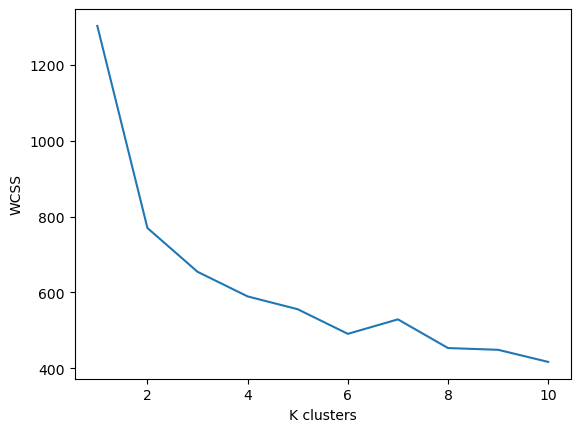

In [18]:
plt.clf()

def find_best_k(max_k):  # Elbow method
    wcss_list = []
    current_k = 1
    
    while(current_k <= max_k):
        current_cluster_centroids = init_random_cluster_centroids(df, current_k)
        old_cluster_centroids = pd.DataFrame()

        while(not current_cluster_centroids.equals(old_cluster_centroids)):
            old_cluster_centroids = current_cluster_centroids
            cluster_labels = get_cluster_label(df, current_cluster_centroids)
            current_cluster_centroids = new_cluster_centroid(df, cluster_labels)

        wcss_list.append(wcss_method(df, current_cluster_centroids))
        current_k+=1

    plt.plot(np.arange(1, max_k+1), wcss_list)

find_best_k(10)
plt.xlabel("K clusters")
plt.ylabel("WCSS")
plt.show()

[5387.802270188035, 2087.4622502107813, 1460.8086036434054, 1216.8199466347685, 913.0163787560191, 837.9898272608584, 741.3550430929552, 722.4380604769658, 660.7335666186159]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

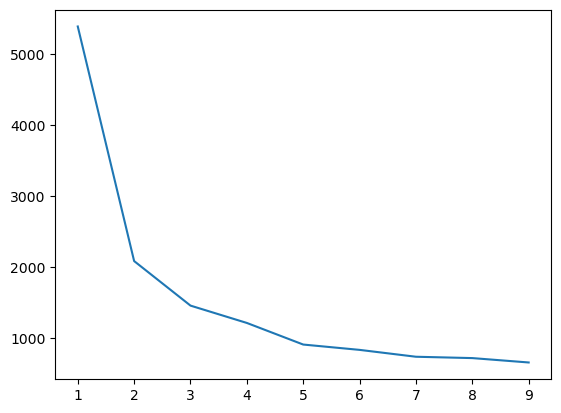

In [19]:
sklearn_wcss_list = []
for i in range(1, 10):
    kMeans = KMeans(n_clusters=i, init="k-means++")
    kMeans.fit(df)
    sklearn_wcss_list.append(kMeans.inertia_)

print(sklearn_wcss_list)
plt.plot(np.arange(1, 10), sklearn_wcss_list)
plt.show()